In [1]:
from collections import OrderedDict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.rcsetup import cycler
from matplotlib import lines as mlines

In [2]:
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.color'] = '0.2'
plt.rcParams['font.size'] = 12
plt.rcParams['text.color'] = '0.2'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelcolor'] = '0.2'
plt.rcParams['axes.prop_cycle'] = cycler('color', ['4b78ca', '467c5a', '7b003d', 'e1883b', 'd9231d', 'eed180', 'd34389', '91b372', 'e7b8cf'])
plt.rcParams['xtick.color'] = '0.2'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.color'] = '0.2'
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.handletextpad'] = 0.4
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['figure.figsize'] = (10.21, 5.71)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['savefig.dpi'] = 125


In [3]:
m2km = 1.60934

In [4]:
austin = pd.read_csv('../input/austin-weather/austin_weather.csv')
delhi = pd.read_csv('../input/delhi-weather-data/testset.csv')
madrid = pd.read_csv('../input/weather_madrid_lemd_1997_2015.csv/weather_madrid_LEMD_1997_2015.csv')
szeged = pd.read_csv('../input/szeged-weather/weatherHistory.csv')

delhi['date'] = pd.DatetimeIndex(delhi['datetime_utc']).date
delhiGrp = delhi.groupby('date')

szeged['date'] = pd.DatetimeIndex(szeged['Formatted Date']).date
szegedGrp = szeged.groupby('date')

rainMsgs = ['Light Rain', 'Drizzle', 'Rain']
szeged['Rain'] = szeged['Summary'].map(lambda msg: any([msg == rainMsg for rainMsg in rainMsgs]))

In [5]:
windSpd = {'austin': austin.loc[austin['WindAvgMPH'] != '-', 'WindAvgMPH'].astype(np.float) * m2km,
          'delhi': delhiGrp[' _wspdm'].mean(),
          'madrid': madrid[' Mean Wind SpeedKm/h'],
          'szeged': szegedGrp['Wind Speed (km/h)'].mean()}
rain = {'austin': austin.loc[austin['PrecipitationSumInches'] != 'T', 'PrecipitationSumInches'].astype(np.float) > 0,
       'delhi': delhiGrp[' _rain'].any(),
       'madrid': madrid['Precipitationmm'] > 0,
       'szeged': szegedGrp['Rain'].agg(any)}
temp = {'austin': (austin['TempHighF'] - 32) * 5 / 9,
       'delhi': delhiGrp[' _tempm'].max(),
       'madrid': madrid['Max TemperatureC'],
       'szeged': szegedGrp['Temperature (C)'].max()}
vis = {'austin': austin.loc[austin['VisibilityHighMiles'] != '-', 'VisibilityHighMiles'].astype(np.float) * m2km,
      'delhi': delhiGrp[' _vism'].max(),
      'madrid': madrid[' Max VisibilityKm'],
      'szeged': szegedGrp['Visibility (km)'].max()}

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


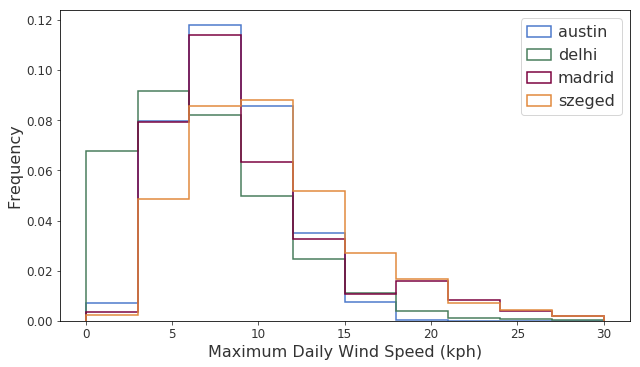

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for key in windSpd.keys():
    ax.hist(windSpd[key], normed=True, histtype='step', label=key, range=(0,30), lw=1.5)
    
ax.legend()
ax.set_xlabel('Maximum Daily Wind Speed (kph)')
ax.set_ylabel('Frequency')

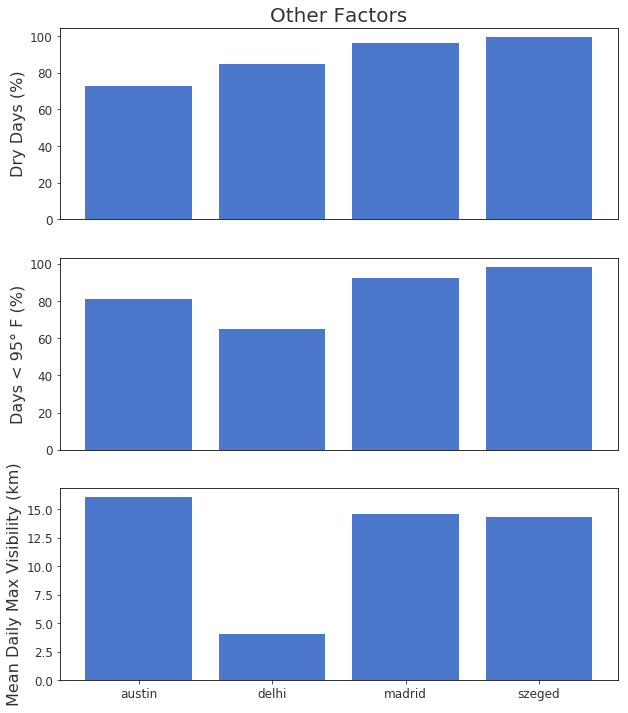

In [7]:
fig = plt.figure(figsize=(10, 12))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

x = [1, 2, 3, 4]

cities = [key for key in rain.keys()]
y1 = [(1 - rain[city].sum() / rain[city].shape[0]) * 100 for city in cities]
y2 = [((temp[city] * 9 / 5 + 32) < 95).sum() / temp[city].shape[0] * 100 for city in cities]
y3 = [vis[city].mean() for city in cities]

ax1.bar(x, y1)
ax2.bar(x, y2)
ax3.bar(x, y3)

ax1.set_ylabel('Dry Days (%)')
ax2.set_ylabel('Days < 95° F (%)')
ax3.set_ylabel('Mean Daily Max Visibility (km)')

ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks(x)
ax3.set_xticklabels(cities)

ax1.set_title('Other Factors')

In [8]:
def avWindDir(windDir, windSpd):
    x = (np.cos(windDir / 360 * 2 * np.pi) * windSpd).sum()
    y = (np.sin(windDir / 360 * 2 * np.pi) * windSpd).sum()
    return np.arctan2(y, x) * 360 / (2 * np.pi) % 360


windDir = {'delhi': delhiGrp.agg(lambda x: avWindDir(x[' _wdird'], x[' _wspdm'])).iloc[:, 0].rename('windDir'),
          'madrid': madrid['WindDirDegrees'],
          'szeged': szegedGrp.agg(lambda x: avWindDir(x['Wind Bearing (degrees)'], x['Wind Speed (km/h)'])).iloc[:, 0].rename('windDir')}

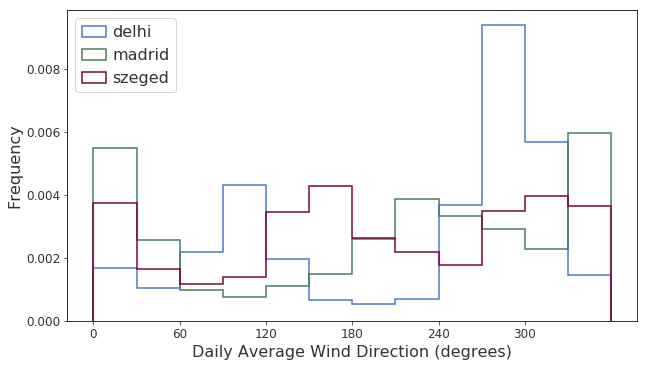

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for key in windDir.keys():
    ax.hist(windDir[key], normed=True, bins=12, histtype='step', label=key, range=(0,360), lw=1.5)
    
ax.legend(loc='upper left')
ax.set_xticks(np.arange(0,360, 60))
ax.set_xlabel('Daily Average Wind Direction (degrees)')
ax.set_ylabel('Frequency')

In [10]:
angleTol = 45
spdTol = 10

testDirs = np.arange(0, 180, 5).reshape(-1, 1)
cities = []
windyDays = []
goodDays = []
angles = []

for city in windDir.keys():
    cities.append(city)
    dirs = windDir[city].values
    spds = windSpd[city].values
    windyDirs = dirs[spds > spdTol]
    windyDays.append(windyDirs.size / dirs.size * 100)
    angleDiffs = (windyDirs - testDirs) % 180
    goodWindyDays = ((angleDiffs < angleTol) | (angleDiffs > (180 - angleTol))).sum(1)
    bestInd = np.argmax(goodWindyDays)
    angles.append(testDirs[bestInd, 0])
    goodDays.append((dirs.size - windyDirs.size + goodWindyDays[bestInd]) / dirs.size * 100)

results = pd.DataFrame(OrderedDict(city=cities,
                                   windyDays=windyDays,
                                   goodDays=goodDays,
                                   angle=angles))
print(results)

     city  windyDays   goodDays  angle
0   delhi  21.406186  97.615479    105
1  madrid  29.770992  92.234292     35
2  szeged  49.290868  85.220204    160


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [11]:
angleTols, spdTols = np.meshgrid(np.linspace(5, 45), np.linspace(5, 25))

def goodDays(angleTol, spdTol, city):
    dirs = windDir[city].values
    spds = windSpd[city].values
    windyDirs = dirs[spds > spdTol]
    angleDiffs = (windyDirs - testDirs) % 180
    goodWindyDays = ((angleDiffs < angleTol) | (angleDiffs > (180 - angleTol))).sum(1)
    return (dirs.size - windyDirs.size + np.max(goodWindyDays)) / dirs.size * 100

sensitivities = {}
for city in windDir.keys():
    sens = np.zeros(angleTols.shape)
    for i in range(angleTols.shape[0]):
        for j in range(angleTols.shape[1]):
            sens[i, j] = goodDays(angleTols[i, j], spdTols[i, j], city)
    sensitivities[city] = sens

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


In [12]:
def addText(ax, text, loc='best', **kwargs):
    '''Doc String'''

    if 'right' in loc:
        markerfirst = False
    else:
        markerfirst = True

    handles = [mlines.Line2D([], [], alpha=0.0)] * len(text)
    ax.legend(handles=handles, labels=text, loc=loc, frameon=False,
              handlelength=0, handletextpad=0, markerfirst=markerfirst,
              **kwargs)
    return

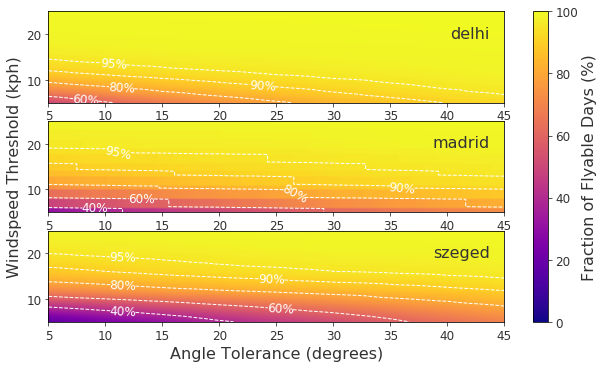

In [13]:
fig = plt.figure()
cmap = plt.get_cmap('plasma')
levels = np.linspace(0, 100, 1000)
cLevels = np.array([40, 60, 80, 90, 95])
formatter = {l: '{:2.0f}%'.format(l) for l in cLevels}
axs = []

for i, city in enumerate(windDir.keys()):
    ax = fig.add_subplot(3, 1, i + 1)
    ax.contourf(angleTols, spdTols, sensitivities[city], levels=levels, cmap=cmap)
    cs = ax.contour(angleTols, spdTols, sensitivities[city], levels=cLevels,
                colors='w', linewidths=1, linestyles='dashed')
    ax.clabel(cs, fmt=formatter)
    addText(ax, [city], loc='upper right')
    
    axs.append(ax)

ax.set_xlabel('Angle Tolerance (degrees)')
axs[1].set_ylabel('Windspeed Threshold (kph)')

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(levels)
cb = fig.colorbar(sm, ax=axs, orientation='vertical')
cb.set_label('Fraction of Flyable Days (%)')